In [1]:
import pandas as pd
import numpy as np
import regex as re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
#from spacy.tokenizer import Tokenizer
from tqdm import tqdm
import contractions
import string
from nltk.tokenize import word_tokenize # must use this for collocations, spacy tokeniser seems incompatible when calcualting pmi score
from unidecode import unidecode


In [2]:
df = pd.read_csv('./data/covid19_articles_20201231.csv')

# Date to datetime
df['date'] = pd.to_datetime(df['date'])

print(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369047 entries, 0 to 369046
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   author      181799 non-null  object        
 1   date        369047 non-null  datetime64[ns]
 2   domain      369047 non-null  object        
 3   title       368962 non-null  object        
 4   url         369047 non-null  object        
 5   content     369047 non-null  object        
 6   topic_area  369047 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 19.7+ MB
None


,author,date,domain,title,url,content,topic_area
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business
1,Thomas Hughes,2020-01-03,marketbeat,Labor Stocks Are Going To Break Out In 2020,https://www.marketbeat.com/originals/labor-sto...,The labor markets were one of the most closely...,business
2,Steve Anderson,2020-01-03,marketbeat,"Tesla (TSLA) Breaks Shipment Record, Beats Est...",https://www.marketbeat.com/originals/teal-brea...,"It could be forgiven, that some might think th...",business


### Drop Article Functions
* Drop duplicates
* Drop long articles
* Drop articles that are annual reports

In [3]:
def drop_articles(df):
    
    df = df.copy()
    
    # Drop duplicates
    num_articles_pre_drop = len(df)
    df = df.drop_duplicates(subset='content')
    print(f'no. articles dropped: {num_articles_pre_drop - len(df)} duplicates')
    
    # Drop long articles
    num_articles_pre_drop = len(df)
    df = df[df['content'].str.len() < 50000]
    print(f'no. articles dropped: {num_articles_pre_drop - len(df)} long articles')
    
    # Drop short articles
    num_articles_pre_drop = len(df)
    df = df[df['content'].str.len() > 50]
    print(f'no. articles dropped: {num_articles_pre_drop - len(df)} short articles')
    
    # Drop articles with annual report as title
    num_articles_pre_drop = len(df)
    df = df[~df['title'].str.contains("Annual Report | Half-yearly financial report | half-year report", na=False)]
    print(f'no. articles dropped: {num_articles_pre_drop - len(df)} annual reports')
    
    # Drop earnings conference call transcripts
    num_articles_pre_drop = len(df)
    df = df[~df['title'].str.contains("earnings conference call | transcript", na=False)]
    print(f'no. articles dropped: {num_articles_pre_drop - len(df)} earnings call transcripts')
    
    print('no. of articles: ', len(df))
    
    return df

In [4]:
test = drop_articles(df)

no. articles dropped: 127 duplicates
no. articles dropped: 3095 long articles
no. articles dropped: 9 short articles
no. articles dropped: 139 annual reports
no. articles dropped: 477 earnings call transcripts
no. of articles:  365200


### Cleaning Functions

TO DO
* Normalise plurals - maybe - https://stackoverflow.com/questions/32404666/python-generating-the-plural-noun-of-a-singular-noun/41830129
* Make code more efficient - tokens.split pass into function rather than doing in every function

In [5]:
def strip_text(text):
    """
    : remove new line and trailing leading whitespace
    """
    return text.strip()

def is_number(text):
    """
    :utility function to test if text is a number
    """
    try:
        float(text) if '.' in text else int(text)
        return True
    except ValueError:
        return False

def remove_numbers(text):
    """
    :remove numbers, percentages, dollar values
    """
    
    regex_percent = re.compile(r'[\-\+]?[\d]+\.?\d*[%]+\.?') # e.g. 3%, -3.8%
    regex_number_fullstop = re.compile(r'\d+[\.]') # e.g. 2019.
    regex_number_fullstop_2 = re.compile(r'\d+\.\d+\.') # e.g. 2019.28.
    regex_dollar_number = re.compile(r'[\$]+[\d,]+\.?\d*') # e.g. $2 or $2.4567
    regex_thousands = re.compile(r'\d+\,\d+') # e.g. 4,000 or 4,000.00
    regex_thousands_2 = re.compile(r'\d+\,\d+\W') # e.g. 4,000 or 4,000.00
    
    percent = regex_percent.findall(text)
    number_fullstop = regex_number_fullstop.findall(text)
    number_fullstop_2 = regex_number_fullstop_2.findall(text)
    dollar_number = regex_dollar_number.findall(text)
    thousands = regex_thousands.findall(text)
    thousands_2 = regex_thousands_2.findall(text)

    word_removals = percent + number_fullstop + number_fullstop_2 + dollar_number + thousands + thousands_2

    tokens = text.split(" ")
    
    # remove integers and floats
    tokens_filtered = [word for word in tokens if not is_number(word)]
    # remove percentages
    tokens_filtered = [word for word in tokens_filtered if word not in word_removals]
    
    text_clean = (" ").join(tokens_filtered)
    
    return text_clean

def remove_emails_tags(text):
    """
    : remove emails and tags (e.g @sleepingbeauty)
    """
    # Add a space before commas to seperate from preceeding word
    text = re.sub(",", " ,", text)
    
    regex_email = re.compile(r'[\w\.-]+@[\w\.-]+.') # email with character at end, e.g. space
    regex_email2 = re.compile(r'[\w\.-]+@[\w\.-]+') # email with no character at end
    regex_tag = re.compile(r'@[\w\.-]+') # tags e.g @sleepingbeauty
    regex_tag = re.compile(r'\S+@[\w\.-]+.') # tags plust character e.g (@sleepingbeauty)
    email = regex_email.findall(text)
    email2 = regex_email2.findall(text)
    tag = regex_tag.findall(text)
    word_removals = email + email2 + tag
    
    tokens = text.split(" ")
    # Remove if email
    tokens_filtered = [word for word in tokens if word not in word_removals]
    
    text_clean = (" ").join(tokens_filtered)
    
    return text_clean

def remove_contraction_possesive_apostrophes(text):
    """
    :remove contraction e.g. can't, won't, she'll -> cant, and possesive apostrophes +s e.g The president's dog -> president
    note: not completely correct as removes 's from e.g. that's which is a contraction rather that possessive, but this is not seen as an issue
    """
    
    #regex_contraction = re.compile(r"[a-zA-Z]+'[a-rt-zA-RT-Z]+|[a-zA-Z]+’[a-rt-zA-RT-Z]+")
    #contraction = regex_contraction.findall(text)
    
    regex_possessive = re.compile(r"[a-zA-Z]+'[sS]+|[a-zA-Z]+’[sS]+")
    possessive = regex_possessive.findall(text)
    
    tokens = text.split(" ")
    
    # remove contractions
    #tokens_filtered = [word if word not in contraction else word.replace("'", "").replace("’","") for word in tokens]
    # replace 's
    tokens_filtered = [word if word not in possessive else word.replace("'s", "").replace("’s","").replace("'S","").replace("’S","") for word in tokens]
    
    text_clean = (" ").join(tokens_filtered)
    
    return text_clean

def expand_contractions(text):
    
    try:
        expanded_text = contractions.fix(text)
    except:
        expanded_text = text
        
    return expanded_text

def remove_punctuation(text):
    """
    :remove english punctuation (note: does not remove non english punctuation, e.g german version of ")
    """
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_long_words(text):
    """
    :remove words that are likely not english or html references
    """
    tokens = text.split(" ")
    tokens_filtered = [word for word in tokens if len(word) < 20 ]
    text_clean = (" ").join(tokens_filtered)
    
    return text_clean

def lowercase_text(text):
    """
    :convert text to lowercase
    """
    return text.lower()

def remove_stopwords(text):
    """
    :remove stopwords
    """
    stop_word_list = spacy.lang.en.stop_words.STOP_WORDS
    tokens = text.split(" ")
    tokens_filtered = [word for word in tokens if word not in stop_word_list]
    tokens_filtered = [word for word in tokens_filtered if word != " "]
    tokens_filtered = [word for word in tokens_filtered if word != ""]
    text_clean = (" ").join(tokens_filtered)
    return text_clean
    
def remove_accents_non_english_char(text):
    """
    :remove accents and non english characters (includes non english punctuation)
    """
    #text_clean = unidecode(text, "utf-8")
    text_clean = unidecode(text)

    return text_clean

In [6]:
#expand_contractions("they're theyre Theyre wont won't Steve's, he's")

In [7]:
test = strip_text(df['content'][2])
test = remove_numbers(test)
test = remove_emails_tags(test)
test = expand_contractions(test)
test = remove_contraction_possesive_apostrophes(test)
test = remove_accents_non_english_char(test)
test = remove_punctuation(test)
test = remove_numbers(test)
test = remove_long_words(test)
test = lowercase_text(test)
print(test)

it could be forgiven  that some might think that tesla nasdaq tsla was little more than a big pile of pieinthesky nonsense yet it seems  these days  that we hear a lot of positive buzz around this maker of electric vehicles that implores we take this company seriously one more brick in the wall of credibility has fallen into place  as recently  tesla reported its delivery and production numbers for the fourth quarter of the news is shockingly good  as evidenced by key phrases like recordbreaking production is off and running the key number for the fourth quarter at tesla was which is how many vehicles were delivered worldwide for the period this not only beat wall street estimates by vehiclesestimates said would go out the doorbut it also beat a goal set up by musk earlier in the year interestingly  if tesla had matched the street estimates  it still would have met musk own goal  so it is a surprise for both entities tesla noted that  in  it delivered a grand total of around vehicles  

In [8]:
remove_stopwords(test)

'forgiven think tesla nasdaq tsla little big pile pieinthesky nonsense days hear lot positive buzz maker electric vehicles implores company seriously brick wall credibility fallen place recently tesla reported delivery production numbers fourth quarter news shockingly good evidenced key phrases like recordbreaking production running key number fourth quarter tesla vehicles delivered worldwide period beat wall street estimates vehiclesestimates said doorbut beat goal set musk earlier year interestingly tesla matched street estimates met musk goal surprise entities tesla noted delivered grand total vehicles represents increase 2018s figures good news stretch sufficient drive percent price increase increase overall year given gains writing handily yesterday close watched pot boiling pretty hard surprising tesla delivery figures watched closely considered best way figure tesla sales numberswhich reasonable obviously selling vehicles delivering unexpected cancellations asideand numbers spot

### Combined Function

In [9]:
def data_preprocessing(df):
    df = df.copy()
    df['content_processed'] = ''
    col_index = df.columns.get_loc('content_processed')
        
    for idx, content in tqdm(enumerate(df['content'])):
        #print(idx)
        #print(idx, 'content: \n',content, '\n')
        text = strip_text(content)
        text = remove_numbers(text)
        #print('numbers: \n', text, '\n')
        text = remove_emails_tags(text)
        #print('emails: \n',text, '\n')
        text = expand_contractions(text)
        text = remove_contraction_possesive_apostrophes(text)
        text = remove_accents_non_english_char(text)
        text = remove_punctuation(text)
        text = remove_numbers(text)
        text = remove_long_words(text)
        text = lowercase_text(text)
        text = remove_stopwords(text)

        df.iat[idx, col_index] = text
        #if idx % 50000 == 0:
         #   print(f'{idx} records processed')
    
    return df
    

# Complete Preprocessing - Step 1 - Cleaning

In [10]:
complete_preprocessing = False

if complete_preprocessing:
    # ~ 30 mins to run
    df_processed = drop_articles(df)
    df_processed = data_preprocessing(df_processed)
    df_processed.to_pickle('./data/df_processed.pickle')
else:
    df_processed = pd.read_pickle('./data/df_processed.pickle')

In [11]:
print(len(df_processed))
df_processed.head(1).append(df_processed.tail(1))

365200


,author,date,domain,title,url,content,topic_area,content_processed
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...
369046,NaN,2020-12-31,marketscreener,FTSE 100 wraps up worst year since 2008 financ...,https://www.marketscreener.com/quote/index/FTS...,"The FTSE 100 lost 1.5%, with consumer stocks, ...",business,ftse lost consumer stocks mainly unilever diag...


## Colocations

Process:
* find collocations
* determine cutoff (at least 50 times present, top 1000 bigrams?)
* search all text and combine bigrams into one word with _ seperator e.g. supply_chain

TO DO
* When converting bigrams, convert highest ranking bigrams first, e.g. a problem is president_donald and donald_trump are both found colocations, but my converting process takes the first words found and so while donald_trump is a better bigram, president_donald is the one that is formed

In [12]:
import nltk
#nltk.download('punkt')
from nltk.collocations import *
from nltk.tokenize import word_tokenize

In [13]:
def tokenise_dataframe(df):

    df = df.copy()
    df['tokens'] = ""
    col_index = df.columns.get_loc("tokens")
    
    for idx, article in enumerate(df['content_processed']):
        tokens = word_tokenize(article)
        df.iat[idx, col_index] = list(tokens)
    
    return df
    
def find_colocations(tokens, min_freq=1000, n_bigrams=2000):
    
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    #trigram_measures = nltk.collocations.TrigramAssocMeasures()
    
    #finder_bigram = BigramCollocationFinder.from_words(tokens)
    #finder_trigram = TrigramCollocationFinder.from_words(tokens)

    finder_bigram = BigramCollocationFinder.from_documents(tokens)
    #finder_trigram = TrigramCollocationFinder.from_documents(tokens)
    
    finder_bigram.apply_freq_filter(min_freq) # minimum number of occurances to be included
    bigrams = finder_bigram.nbest(bigram_measures.pmi, n_bigrams)
    df_bigrams_freq = pd.DataFrame(finder_bigram.ngram_fd.items(), columns=['bigram', 'freq'])

    return bigrams, df_bigrams_freq

In [14]:
test_token = tokenise_dataframe(df_processed[:1000])
test_bigrams, test_df_bigrams_freq = find_colocations(test_token['tokens'])

In [15]:
test_bigrams[:5]

[]

In [16]:
def create_bigrams_article(text, bigrams):
    """
    :convert bigrams to one word for an individual article
    used within create_bigrams function
    """

    tokens = text.split(" ")
    tokens_with_bigrams = []
    idx = 0
    while idx < len(tokens) -1:
        if (tokens[idx], tokens[idx+1]) in bigrams:
            bigram = str(tokens[idx]) + '_' + str(tokens[idx+1])
            tokens_with_bigrams.append(bigram)
            idx += 2
        else:
            tokens_with_bigrams.append(tokens[idx])
            idx += 1
    if (tokens[-2], tokens[-1]) not in bigrams:
        tokens_with_bigrams.append(tokens[-1])

    text_clean = (" ").join(tokens_with_bigrams)
    
    return text_clean
        
def create_bigrams(df, min_freq=1000, n_bigrams=2000):
    """
    :convert bigrams to one word for entire df
    """
    
    df = df.copy()
    col_index = df.columns.get_loc('content_processed')
    
    df_tokenised = tokenise_dataframe(df)
    print('df tokenised')
    tokens = df_tokenised['tokens']
    
    bigrams, df_bigrams_freq = find_colocations(tokens, min_freq, n_bigrams)
    print('bigrams found')
            
    for idx, content in tqdm(enumerate(df['content_processed'])):
        text = create_bigrams_article(content, bigrams)
        df.iat[idx, col_index] = text
        #if idx % 50000 == 0:
         #   print(f'{idx} records processed')
            
    return bigrams, df, df_bigrams_freq

# Complete Preprocessing - Step 2 - Colocations

In [ ]:
complete_preprocessing = True

if complete_preprocessing:
    # ~ 1 hours to run
    df_processed = pd.read_pickle('./data/df_processed.pickle')
    bigrams, df_processed_bigrams, df_bigrams_freq = create_bigrams(df_processed)
    df_processed_bigrams.to_pickle('./data/df_processed_bigrams.pickle')
    
    df_bigrams = pd.DataFrame(bigrams, columns=['bigram_w1', 'bigram_w2'])
    df_bigrams['freq'] = ''
    for idx in range(len(df_bigrams)):
        bigram_check = (df_bigrams['bigram_w1'][idx], df_bigrams['bigram_w2'][idx])
        freq = df_bigrams_freq[df_bigrams_freq['bigram'] == bigram_check]['freq'].values[0]
        df_bigrams.loc[idx, 'freq'] = freq
    df_bigrams.to_csv('./data/bigrams.csv', index=False)
    df_bigrams_freq.to_csv('./data/df_bigrams_freq.csv', index=False)
    
else:
    df_processed_bigrams = pd.read_pickle('./data/df_processed_bigrams.pickle')
    df_bigrams = pd.read_csv('./data/bigrams.csv')
    df_bigrams_freq = pd.read_csv('./data/df_bigrams_freq.csv')

df tokenised


3it [00:00, 28.42it/s]

bigrams found


254213it [1:46:58, 47.21it/s]

In [21]:
df_bigrams_freq[df_bigrams_freq['freq'] < 50000]

,bigram,freq
0,"(end, year)",13015
1,"(time, think)",1301
2,"(market, leader)",1328
3,"(energy, sector)",1788
4,"(expected, grow)",2722
...,...,...
8596,"(15year, perspective)",2571
8597,"(presidentelect, joe)",1877
8598,"(content, december)",1172
8599,"(unaltered, december)",1232


In [27]:
df_bigrams_freq[df_bigrams_freq['bigram'] == ('supply', 'chains')]

,bigram,freq
137,"(supply, chains)",9493


<AxesSubplot:>

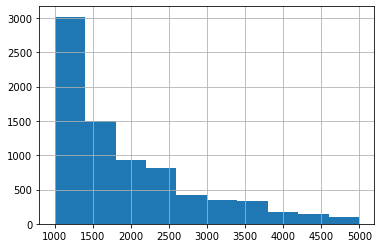

In [22]:
#df_bigrams_freq['freq'].hist()
df_bigrams_freq[df_bigrams_freq['freq'] < 5000]['freq'].hist()

In [9]:
print(len(df_processed_bigrams))
df_processed_bigrams.head(1).append(df_processed_bigrams.tail(1))

365200


,author,date,domain,title,url,content,topic_area,content_processed
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...
369046,NaN,2020-12-31,marketscreener,FTSE 100 wraps up worst year since 2008 financ...,https://www.marketscreener.com/quote/index/FTS...,"The FTSE 100 lost 1.5%, with consumer stocks, ...",business,ftse lost consumer stocks mainly unilever diag...


In [28]:
df_bigrams[20:40]

,bigram_w1,bigram_w2,freq
20,thermo,fisher,1204
21,fiat,chrysler,2061
22,hk000,hk000,1156
23,navigator,evaluates,1025
24,timo,werner,1145
25,thread,preparatory,1484
26,jacinda,ardern,1166
27,jurgen,klopp,1636
28,tedros,adhanom,1979
29,borussia,dortmund,1654


In [125]:
df_bigrams[df_bigrams['bigram_w1'] == 'supply']

,bigram_w1,bigram_w2,freq
960,supply,chains,9490
992,supply,chain,23584


In [121]:
df_bigrams[df_bigrams['freq'] <= 100]

,bigram_w1,bigram_w2,freq


In [111]:
df_bigrams[(df_bigrams['freq'] >= 700) & (df_bigrams['freq'] <= 1000)]

,bigram_w1,bigram_w2,freq
1476,mapelli,mozzi,719
1541,marguerita,choy,773
1559,oyu,tolgoi,742
1594,anglogold,ashanti,733
1612,buenos,aires,768
1700,shounak,dasgupta,872
1756,estados,unidos,794
1782,tamil,nadu,866
1829,arun,koyyur,749
1881,shri,navaratnam,801


In [99]:
df_bigrams[df_bigrams['bigram_w1'] == 'supply']

,bigram_w1,bigram_w2,freq


In [122]:
df_bigrams_freq

,bigram,freq
0,"(end, year)",13003
1,"(time, think)",1193
2,"(market, leader)",1326
3,"(energy, sector)",1784
4,"(expected, grow)",2718
...,...,...
9074,"(15year, perspective)",2571
9075,"(presidentelect, joe)",1875
9076,"(content, december)",1172
9077,"(unaltered, december)",1232


In [123]:
df_bigrams_freq[df_bigrams_freq['bigram'] == ('supply', 'chain')]

,bigram,freq
438,"(supply, chain)",23584


### Strip company names out of text
Just an idea to come back to because otherwise they may form significance for topic

In [255]:
print(df['content'][0])

With the end of the year just around the corner, it’s past time to think about positioning for2020. When it comes to earnings power in 2020, the Industrial sector is going to be the market leader and that is where I like my money to be. To be clear, when I say Industrial Sector I mean the S&P 500 Industrial Sector as represented by the ETF (XLI). Yes, the Energy Sector is expected to post EPS growth double that of the Industrials but investors should take that news with a grain of salt. The Energy Sector’s (XLE) consensus EPS growth estimate for 2020 is 21% but only after falling -28% this year. The Industrial Sector is expected to grow by 15% next year (2nd fastest pace for the S&P 500) after contracting only -3% this year. That means the Energy Sector’s earnings will still be down on a two-year basis while the Industrial’s will rise. Energy may yet turn out to be a good investment for 2020 but, on an earnings basis, the Industrials are a much better choice. Don’t Bet On Boeing Boeing